In [1]:
from flyanalysis import braidz
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from typing import List
import random
from matplotlib import colormaps
import pycircstat

In [31]:
def read_single_file(file_path: str):
    return braidz.read_braidz(file_path)

def get_angular_velocity(df, idx_before, idx_after):
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    thetas = np.arctan2(yvel, xvel)
    thetas_u = np.unwrap(thetas)
    angular_velocity = np.gradient(thetas_u) / (0.01)

    return np.rad2deg(angular_velocity[idx_before:idx_after])

def get_linear_velocity(df, idx_before, idx_after):
    xvel = df["xvel"].to_numpy()
    yvel = df["yvel"].to_numpy()

    linvel = np.sqrt(xvel**2 + yvel**2)
    return linvel[idx_before:idx_after]

def get_trajectory(df, idx_before, idx_after):
    return df[["x", "y", "z"]].to_numpy()[idx_before:idx_after]

def get_mean_and_std(data: np.array, abs: bool = False):
    if abs:
        return np.mean(np.abs(data), axis=0), np.std(np.abs(data), axis=0)
    else:
        return np.mean(data, axis=0), np.std(data, axis=0)
    
def plot_with_mean_and_std(data: np.array, label=None, ax=None, xlabel=None, ylabel=None):
    if ax is None:
        ax = plt.gca()

    mean, std = get_mean_and_std(data, abs=True)
    
    X = np.arange(len(mean))
    ax.plot(X, mean, label=label)
    ax.fill_between(X, mean - std, mean + std, alpha=0.5)

    if label:
        ax.legend()
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def rotate_trajectory(trajectory, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    return np.dot(trajectory, rotation_matrix.T)

def translate_trajectory(trajectory, heading_dt=10):
    # Calculate initial heading (using points up to index 10)
    initial_vector = trajectory[heading_dt] - trajectory[0]
    initial_angle = np.arctan2(initial_vector[1], initial_vector[0])

    # Rotate the trajectory to align with positive y-axis
    rotation_angle = np.pi/2 - initial_angle
    rotated_trajectory = rotate_trajectory(trajectory, rotation_angle)

    # Translate to start from (0,0)
    translated_trajectory = rotated_trajectory - rotated_trajectory[0]

    return translated_trajectory

def align_and_rotate_trajectories(
    coordinates: List[np.array],
    start_idx: int = 50,
    end_idx: int = 100,
    heading_dt: int = 10,
) -> List[np.array]:
    rotated_trajectories = []

    for traj in coordinates:
        traj = traj[start_idx:end_idx, :2]
        aligned_trajectory = translate_trajectory(traj, heading_dt=heading_dt)
        rotated_trajectories.append(aligned_trajectory)
    return rotated_trajectories

def get_dispersion(groups: List[List[np.array]]):
    dispersion = [[] for _ in range(len(groups))]
    for i, group_trajectories in enumerate(groups):
        for traj in group_trajectories:
            heading_angle = np.arctan2(traj[-1,1] - traj[0,1], traj[-1,0] - traj[0,0])
            dispersion[i].append(heading_angle)
    return dispersion

def angdiff(angle1: float, angle2: float, range_start: float = -np.pi, range_end: float = np.pi) -> float:
    """
    Calculate the shortest angular difference between two angles.

    Parameters:
    angle1 (float): First angle in radians
    angle2 (float): Second angle in radians
    range_start (float): Start of the angle range (default: -pi)
    range_end (float): End of the angle range (default: pi)

    Returns:
    float: Shortest angular difference in radians
    """
    # Ensure the angles are within the specified range
    def normalize_angle(angle):
        range_size = range_end - range_start
        return (angle - range_start) % range_size + range_start

    angle1 = normalize_angle(angle1)
    angle2 = normalize_angle(angle2)

    # Calculate the raw difference
    diff = angle2 - angle1

    # Adjust the difference to find the shortest angular distance
    range_size = range_end - range_start
    if diff > range_size / 2:
        diff -= range_size
    elif diff < -range_size / 2:
        diff += range_size

    return diff

def calculate_heading_change(trajectories: np.array, central_point: int = 50, dt_before: int = 10, dt_after: int = 50) -> np.array:
    """
    Calculate the change in heading for each trajectory.
    
    :param trajectories: numpy array of shape [n, 150, 3]
    :param central_point: int, index of the central point (0-149)
    :param dt_before: int, number of points to consider before the central point
    :param dt_after: int, number of points to consider after the central point
    :return: numpy array of shape [n] containing heading changes in radians
    """
    
    n = trajectories.shape[0]
    heading_changes = np.zeros(n)
    
    for i in range(n):
        trajectory = trajectories[i]
        
        # Calculate points to use for before and after vectors
        before_point = max(0, central_point - dt_before)
        after_point = min(149, central_point + dt_after)
        
        # Extract before and after vectors (considering only x and y components)
        before_vector = trajectory[central_point, :2] - trajectory[before_point, :2]
        after_vector = trajectory[after_point, :2] - trajectory[central_point, :2]
        
        # Calculate angles
        before_angle = np.arctan2(before_vector[1], before_vector[0])
        after_angle = np.arctan2(after_vector[1], after_vector[0])
        
        # Calculate heading change
        heading_change = after_angle - before_angle
        
        # Normalize to [-pi, pi]
        heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi
        
        heading_changes[i] = heading_change
    
    return heading_changes


def plot_polar_histogram(groups: List[np.array], labels: List[str], bins: int = 36, ax=None, central_point: int = 50, dt_before: int = 0, dt_after: int = 50):
    """
    Plots a normalized polar histogram of the heading angles for multiple groups.

    Args:
    - groups: A list of groups, where each group is a list of np.array trajectories (each of shape (n, 3)).
    - labels: A list of strings representing the label for each group.
    - bins: Number of bins in the histogram (default is 36).
    """
    if len(groups) != len(labels):
        raise ValueError("Number of groups must match the number of labels.")
    
    if ax is None:
        ax = plt.gca()
    
    # Define a set of colors for different groups
    colors = colormaps["tab10"]  # Use a colormap with sufficient distinct colors

    headings = [[] for _ in range(len(groups))]

    # Plot each group's heading angles on a polar histogram
    for i, group in enumerate(groups):
        ax.hist(group, bins=bins, color=colors(i), alpha=0.6, label=labels[i], density=True)
    # Adjust the orientation
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)
    ax.set_title('Normalized Polar Histogram of Heading Angles')
    ax.legend()

def plot_dispersions(groups: List[List[np.array]], labels: List[str], ax=None):
    """
    Plots the XY parts of trajectories for multiple groups in a 2D plot.

    Args:
    - groups: A list of groups, where each group is a list of np.array trajectories (each of shape (n, 3)).
    - labels: A list of strings representing the label for each group.

    """
    if len(groups) != len(labels):
        raise ValueError("Number of groups must match the number of labels.")
    
    if ax is None:
        ax = plt.gca()

    # Define a set of colors for different groups
    colors = colormaps["tab10"]  # Use a colormap with sufficient distinct colors

    # Plot each group
    for i, group in enumerate(groups):
        for traj in group:
            ax.plot(traj[:, 0], traj[:, 1], color=colors(i), alpha=0.5)
        
        # Calculate and plot the mean trajectory for the group
        mean_traj = np.mean(np.stack(group), axis=0)
        ax.plot(mean_traj[:, 0], mean_traj[:, 1], color=colors(i), linewidth=3, label=labels[i])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Trajectory Dispersion Comparison')
    ax.legend()
    ax.grid(True)

def plot_trajectory(data: np.array, ax=None, label=None, color="k", stim=False):
    if ax is None:
        ax = plt.gca()

    for i, d in enumerate(data):
        if i > 0:
            label = None
        ax.plot(d[:, 0], d[:, 1], color=color, label=label)
        ax.scatter(d[0, 0], d[0, 1], color="red")
        
        if stim:
            ax.plot(d[50:80, 0], d[50:80, 1], color="red")
    
    ax.legend()
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

def get_data(df: pd.DataFrame, stim: pd.DataFrame, keys: list | str):
    keys = [keys] if isinstance(keys, str) else keys
    data_dict = {key: [] for key in keys}

    extraction_functions = {
        "angular_velocity": get_angular_velocity,
        "linear_velocity": get_linear_velocity,
        "xyz": get_trajectory,
    }

    for _, row in stim.iterrows():
        try:
            obj_id = int(row["obj_id"])
            frame = int(row["frame"])
        except ValueError:
            continue

        obj_group = df[df["obj_id"] == obj_id]
        frame_indices = np.where(obj_group["frame"] == frame)[0]
        if len(frame_indices) == 0:
            continue
    
        frame_idx = frame_indices[0]

        idx_before = frame_idx - 50
        idx_after = frame_idx + 100

        if idx_before < 0 or idx_after >= len(obj_group):
            continue

        for key in keys:
            if key not in extraction_functions:
                raise ValueError(f"Key {key} not recognized.")
            data_dict[key].append(extraction_functions[key](obj_group, idx_before, idx_after))

    for key in keys:
        if key != "xyz":
            data_dict[key] = np.array(data_dict[key])

    return data_dict

def process_single_file(file_data, keys):
    df = file_data[0]
    stim = file_data[1]['stim'] if 'stim' in file_data[1] else file_data[1]['opto']
    return get_data(df, stim, keys)

def process_files(file_list: list, root_folder: str, keys: list):
    combined_data = defaultdict(list)
    file_sources = defaultdict(list)
    
    for file in file_list:
        file_path = os.path.join(root_folder, file)
        print(f"Processing file: {file}")
        
        try:
            file_data = read_single_file(file_path)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
            continue
        
        try:
            file_results = process_single_file(file_data, keys)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
            continue
        
        for key in keys:
            combined_data[key].extend(file_results[key])
            file_sources[key].extend([file] * len(file_results[key]))
        
        del file_data
    
    for key in keys:
        combined_data[key] = np.array(combined_data[key])
    
    return dict(combined_data), dict(file_sources)

In [3]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
keys = ["angular_velocity", "linear_velocity", "xyz"]

# CsChrimson Bilateral

## J53 vs J64 (DNp03 vs Empty-Split)

In [4]:
# Process j53xu68 files
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data, j53_sources = process_files(j53xu68_files, root_folder, keys)

Processing file: 20230321_162524.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230321_162524.braidz using pyarrow
Processing file: 20230519_130210.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230519_130210.braidz using pyarrow


In [5]:
# Process emptyxu68 files
emptyxu68_files = ["20220921_102343.braidz", "20221007_155629.braidz", "20221011_115957.braidz"]
empty_data, empty_sources = process_files(emptyxu68_files, root_folder, keys)

Processing file: 20220921_102343.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20220921_102343.braidz using pyarrow
Processing file: 20221007_155629.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20221007_155629.braidz using pyarrow
Processing file: 20221011_115957.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20221011_115957.braidz using pyarrow


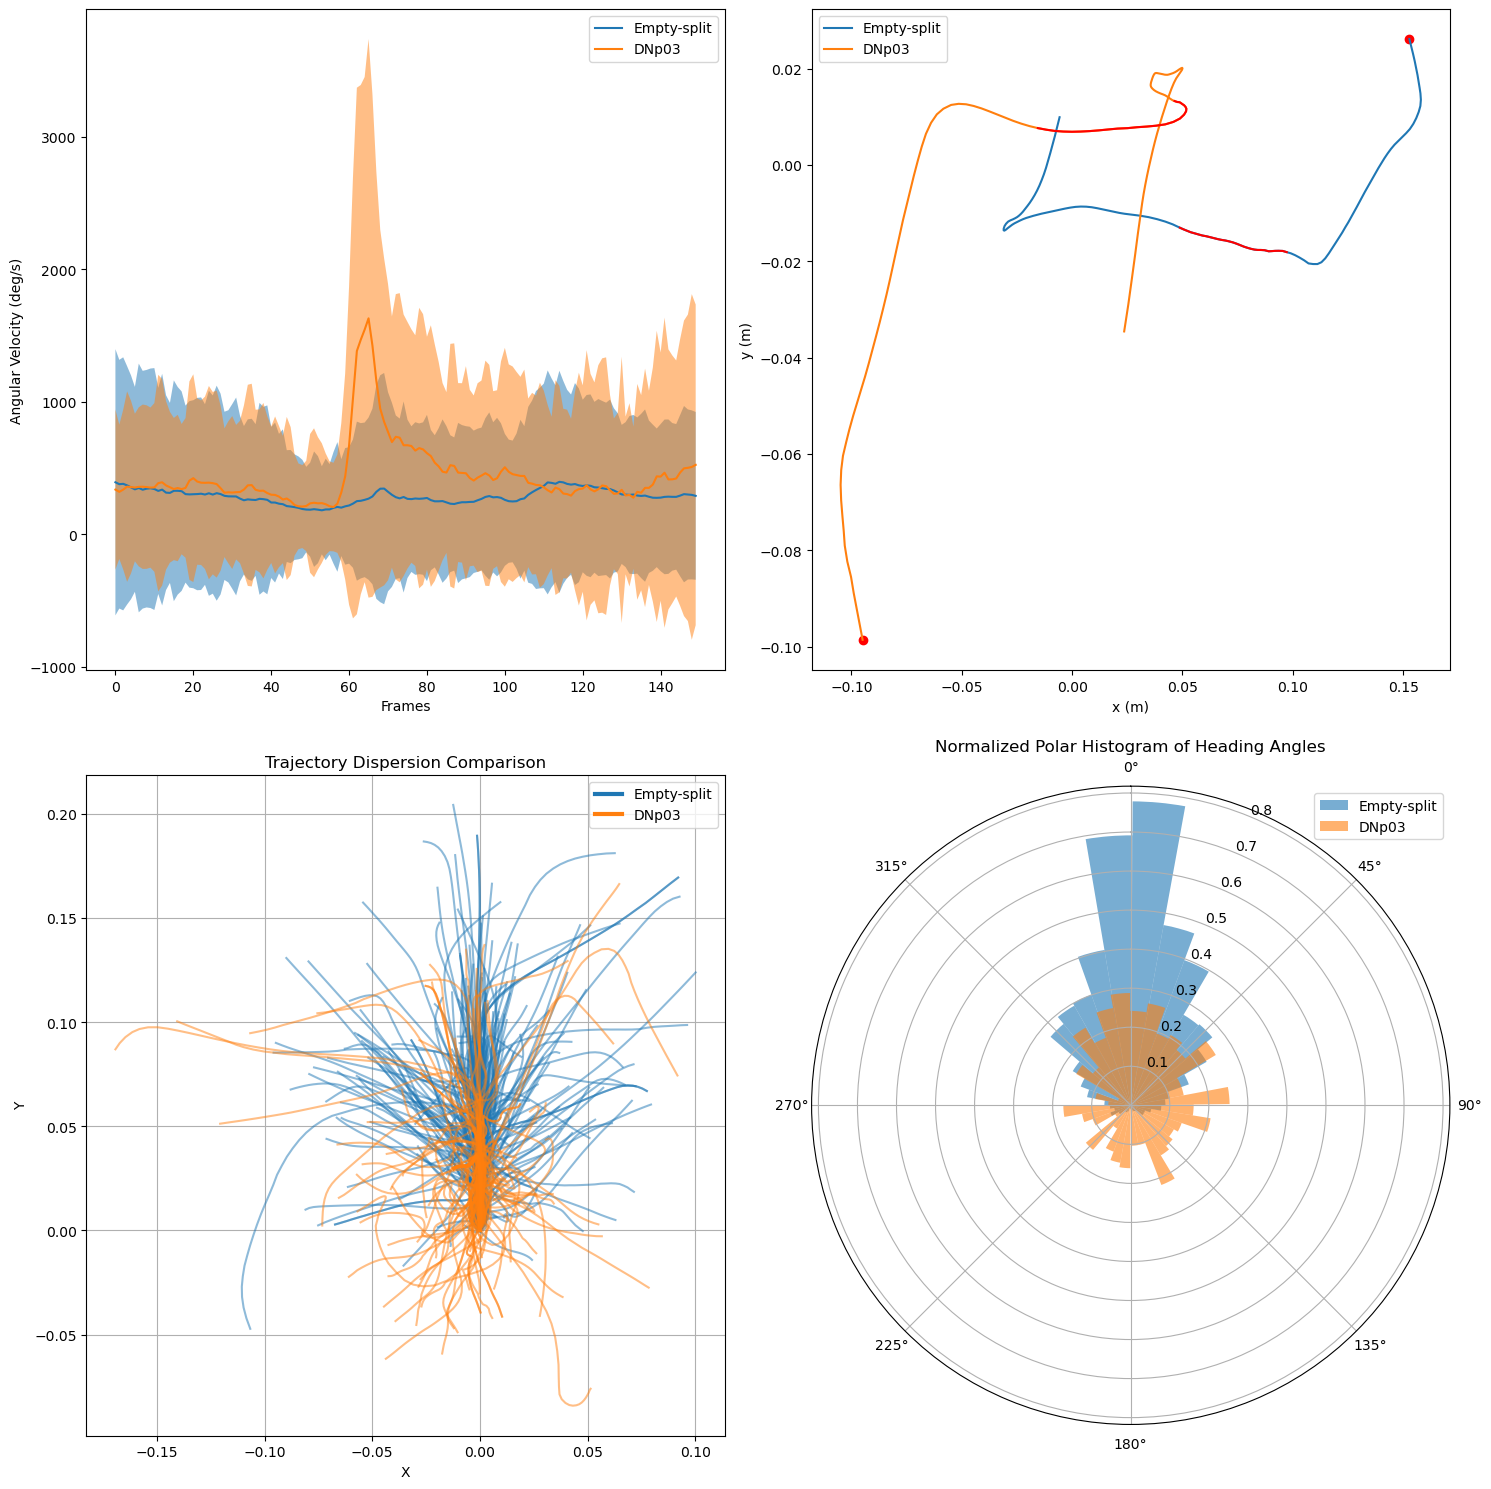

<Figure size 640x480 with 0 Axes>

In [34]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4, projection="polar")

# plot angular velocity
plot_with_mean_and_std(empty_data["angular_velocity"], label="Empty-split", ax=ax1, xlabel="Frames", ylabel="Angular Velocity (deg/s)")
plot_with_mean_and_std(j53_data["angular_velocity"], label="DNp03", ax=ax1)

# plot a random sample of trajectories
k = 1
plot_trajectory(random.choices(empty_data["xyz"], k=k), ax=ax2, color=colormaps["tab10"](0), label="Empty-split", stim=True)
plot_trajectory(random.choices(j53_data["xyz"], k=k), ax=ax2, color=colormaps["tab10"](1), label="DNp03", stim=True)

# plot rotated trajectories
rotated_trajectories_empty = align_and_rotate_trajectories(empty_data["xyz"])
rotated_trajectories_j53 = align_and_rotate_trajectories(j53_data["xyz"])

plot_dispersions([random.choices(rotated_trajectories_empty, k=250), random.choices(rotated_trajectories_j53, k=100)], ["Empty-split", "DNp03"], ax=ax3)

heading_change_empty = calculate_heading_change(empty_data["xyz"], central_point=50, dt_before=10, dt_after=60)
heading_change_j53 = calculate_heading_change(j53_data["xyz"], central_point=50, dt_before=10, dt_after=60)
headings = plot_polar_histogram([heading_change_empty, heading_change_j53], ["Empty-split", "DNp03"], ax=ax4)
plt.tight_layout()
plt.show()

plt.savefig('/home/buchsbaum/Documents/j53_vs_empty.pdf', dpi=300)
plt.savefig('/home/buchsbaum/Documents/j53_vs_empty.svg', dpi=300)

## G29 vs J64 (AX vs Empty Split)

In [12]:
# Process g29xu68 files
g29xu68_files = ["20230512_144203.braidz"]
g29_data, g29_sources = process_files(g29xu68_files, root_folder, keys)

Processing file: 20230512_144203.braidz
Reading /home/buchsbaum/mnt/md0/Experiments/20230512_144203.braidz using pyarrow


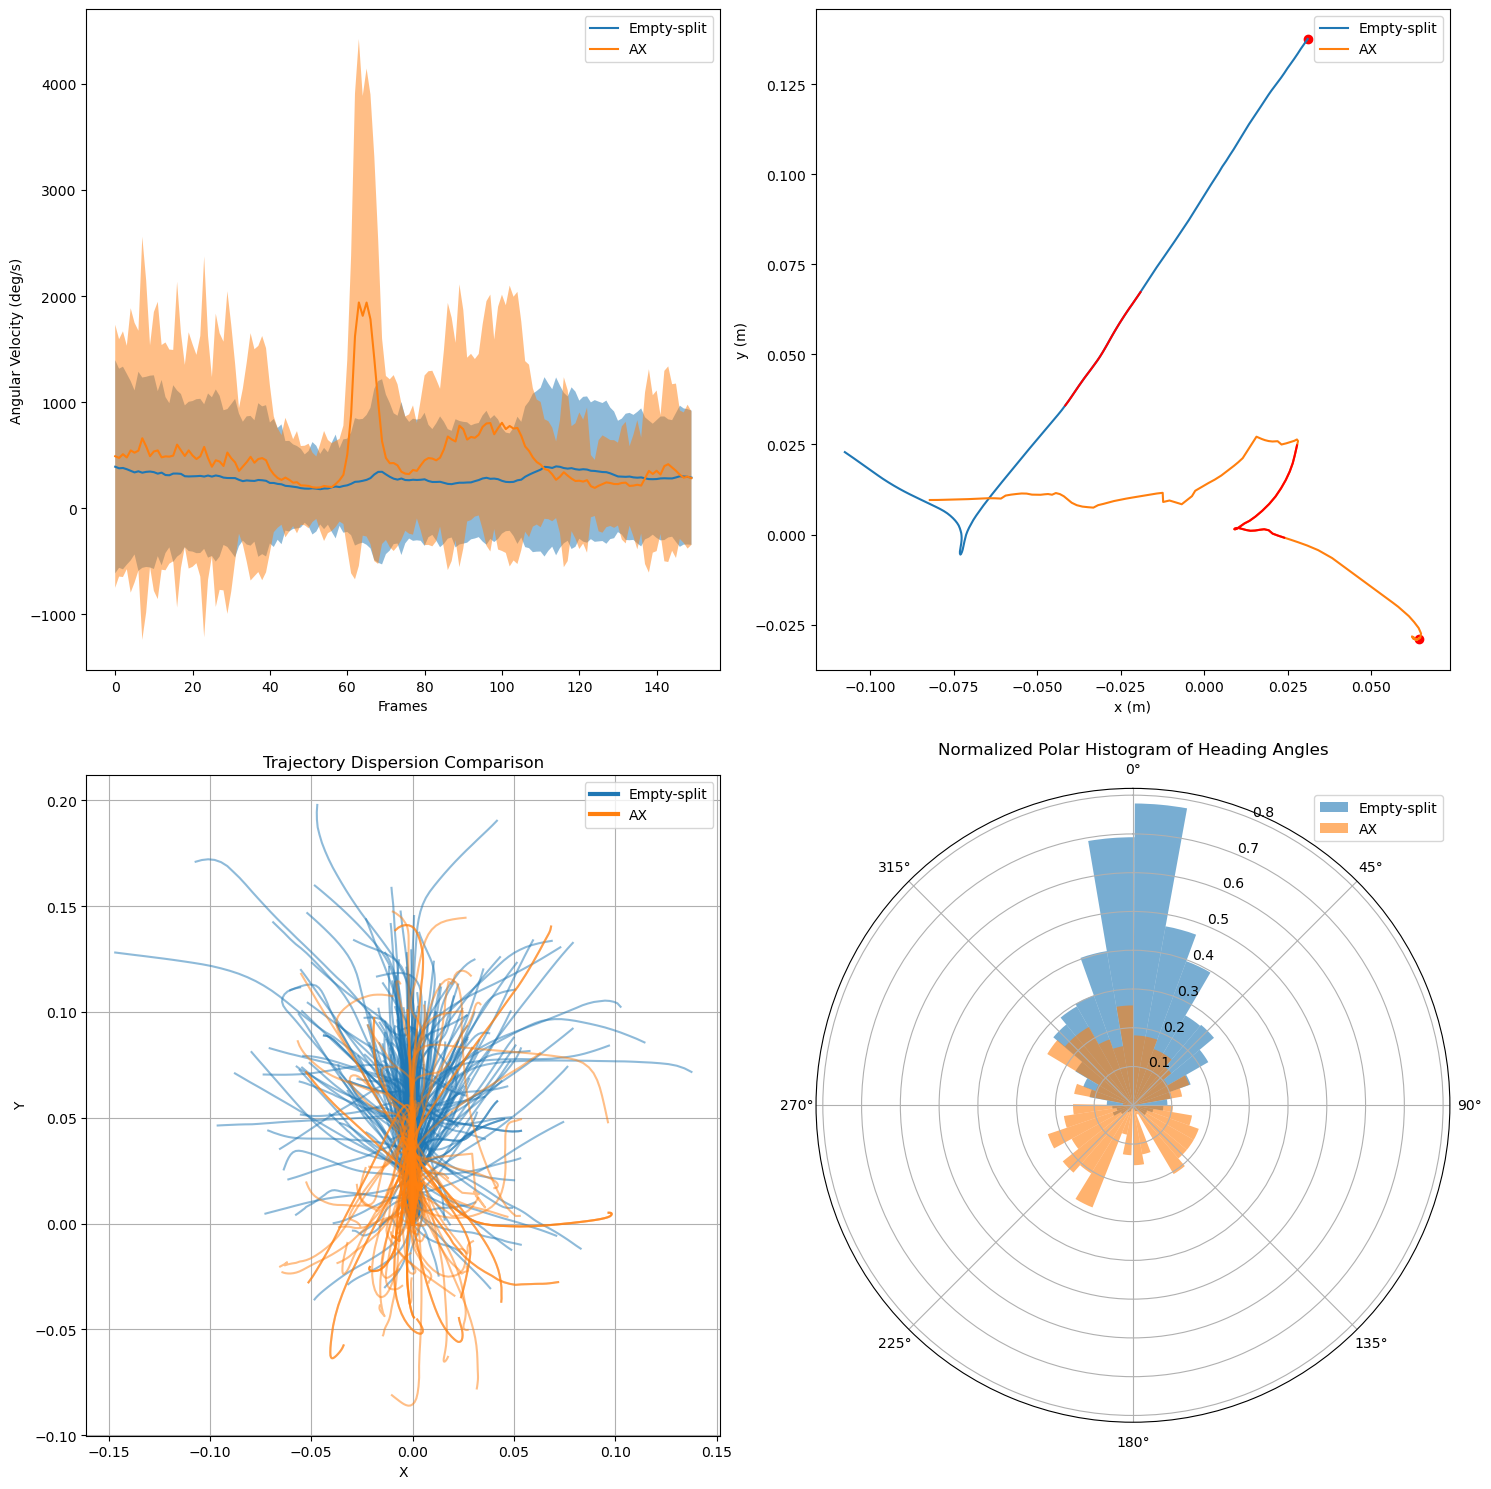

<Figure size 640x480 with 0 Axes>

In [33]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4, projection="polar")

# plot angular velocity
plot_with_mean_and_std(empty_data["angular_velocity"], label="Empty-split", ax=ax1, xlabel="Frames", ylabel="Angular Velocity (deg/s)")
plot_with_mean_and_std(g29_data["angular_velocity"], label="AX", ax=ax1)

# plot a random sample of trajectories
k = 1
plot_trajectory(random.choices(empty_data["xyz"], k=k), ax=ax2, color=colormaps["tab10"](0), label="Empty-split", stim=True)
plot_trajectory(random.choices(g29_data["xyz"], k=k), ax=ax2, color=colormaps["tab10"](1), label="AX", stim=True)

# plot rotated trajectories
rotated_trajectories_empty = align_and_rotate_trajectories(empty_data["xyz"])
rotated_trajectories_j53 = align_and_rotate_trajectories(g29_data["xyz"])

plot_dispersions([random.choices(rotated_trajectories_empty, k=250), random.choices(rotated_trajectories_j53, k=100)], ["Empty-split", "AX"], ax=ax3)

heading_change_empty = calculate_heading_change(empty_data["xyz"], central_point=50, dt_before=10, dt_after=60)
heading_change_g29 = calculate_heading_change(g29_data["xyz"], central_point=50, dt_before=10, dt_after=60)
headings = plot_polar_histogram([heading_change_empty, heading_change_g29], ["Empty-split", "AX"], ax=ax4)
plt.tight_layout()
plt.show()

plt.savefig('/home/buchsbaum/Documents/g29_vs_empty.pdf', dpi=300)
plt.savefig('/home/buchsbaum/Documents/g29_vs_empty.svg', dpi=300)

In [22]:
print(len(g29_data['xyz']), len(g29_data['xyz'].tolist()))

224 224


## Kir2.1 Analysis

In [17]:
import flyanalysis as fa

In [18]:
# Process j53xkir files
j53_kir_files = "/home/buchsbaum/mnt/DATA/Experiments/20240618_134153.braidz"
j53_df, j53_csvs = fa.braidz.read_braidz(j53_kir_files)

Reading /home/buchsbaum/mnt/DATA/Experiments/20240618_134153.braidz using pyarrow


In [19]:
j64_kir_files = "/home/buchsbaum/mnt/DATA/Experiments/20240808_111028.braidz"
j64_df, j64_csvs = fa.braidz.read_braidz(j64_kir_files)

Reading /home/buchsbaum/mnt/DATA/Experiments/20240808_111028.braidz using pyarrow


In [26]:
from scipy.signal import savgol_filter
def get_angvels(df, csvs):
    angvels = []
    linvels = []
    xyzs = []
    for idx, row in csvs["opto"].iterrows():
        obj_id = int(row["obj_id"])
        frame = int(row["frame"])

        obj_df = df[df["obj_id"] == obj_id]

        stim_idx = np.where(obj_df["frame"] == frame)[0][0]
        
        idx_before = stim_idx-50
        idx_after = stim_idx+100

        if idx_before < 0 or idx_after >= len(obj_df):
            continue

        if (0.15<=row["z"]<=0.25):
            xvel = savgol_filter(obj_df["xvel"].to_numpy(), 51, 3)
            yvel = savgol_filter(obj_df["yvel"].to_numpy(), 51, 3)

            theta = np.arctan2(yvel, xvel)
            theta_unwrap = np.unwrap(theta)
            angvel = np.gradient(theta_unwrap, 0.01)

            linvel = np.sqrt(xvel**2 + yvel**2)

            angvels.append(angvel[idx_before:idx_after])
            linvels.append(linvel[idx_before:idx_after])
            xyzs.append(obj_df[["x", "y", "z"]].to_numpy()[idx_before:idx_after])
        else:
            continue

    angvels = np.array(angvels)
    return angvels, linvels, xyzs

In [27]:
j53_angvels, j53_linvels, j53_xyzs = get_angvels(j53_df, j53_csvs)
j64_angvels, j64_linvels, j64_xyzs = get_angvels(j64_df, j64_csvs)

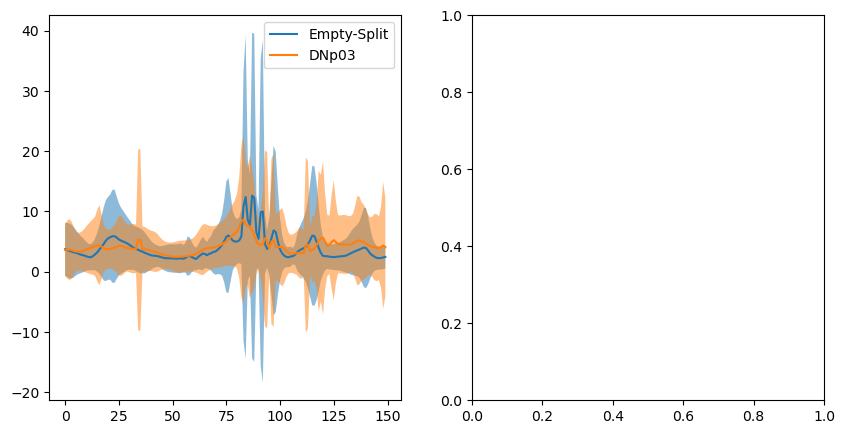

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

# plot angular velocity
plot_with_mean_and_std(j64_angvels, label="Empty-Split", ax=axs[0])
plot_with_mean_and_std(j53_angvels, label="DNp03", ax=axs[0])

plt.show()